In [2]:
from pyspark import SparkContext
sc = SparkContext()

In [3]:
import re
from collections import namedtuple

%matplotlib inline
import matplotlib.pyplot as plt

In [4]:
# wget https://github.com/matplotlib/basemap/archive/v1.0.7rel.tar.gz
# tar -zxvf v1.0.7rel.tar.gz && cd basemap-1.0.7rel/
# cd geos-3.3.3
# export GEOS_DIR=/usr/local
# ./configure --prefix=$GEOS_DIR 
# make; make install
# cd ../ && python setup.py install
from mpl_toolkits.basemap import Basemap

In [5]:
coordinates = namedtuple("coordinates", ['codice_istat','sottoarea','lat','lon','citta', 'provincia','regione','zona_italia',
                                         'isola', 'abitanti','min_distanza', 'densita'])

In [6]:
from geopy.geocoders import Nominatim
geolocator = Nominatim()
def do_parse_coordinates(x):
    return coordinates(
        codice_istat = '',
        sottoarea = int(re.sub("[^0-9]", "", x[0])),
        lat = float(x[1]),
        lon = float(x[2]),
        citta = '',
        provincia = '',
        regione = '',
        zona_italia = '',
        isola = '',
        abitanti = '',
        min_distanza = '',
        densita = '',
        )

def parse_coordinates(sc,filepath):
    rawRdd = sc.textFile(filepath)
    header = rawRdd.first()

    # Togliamo l'header
    rawRdd = rawRdd.filter(lambda x: x != header)
    
    return rawRdd.map(lambda x: x.split(",")).map(lambda x: do_parse_coordinates(x))

In [7]:
rddCoordinates = parse_coordinates(sc,"dataset/gps.csv")

In [9]:
rddCoordinates.take(5)

[coordinates(codice_istat='', sottoarea=1, lat=37.57251433333334, lon=14.20335411764705, citta='', provincia='', regione='', zona_italia='', isola='', abitanti='', min_distanza='', densita=''),
 coordinates(codice_istat='', sottoarea=2, lat=37.33710751515152, lon=13.54329624242424, citta='', provincia='', regione='', zona_italia='', isola='', abitanti='', min_distanza='', densita=''),
 coordinates(codice_istat='', sottoarea=3, lat=45.331017128571396, lon=8.264631871428566, citta='', provincia='', regione='', zona_italia='', isola='', abitanti='', min_distanza='', densita=''),
 coordinates(codice_istat='', sottoarea=4, lat=44.83720054450263, lon=8.639266298429321, citta='', provincia='', regione='', zona_italia='', isola='', abitanti='', min_distanza='', densita=''),
 coordinates(codice_istat='', sottoarea=5, lat=42.49907295757578, lon=13.76170830909092, citta='', provincia='', regione='', zona_italia='', isola='', abitanti='', min_distanza='', densita='')]

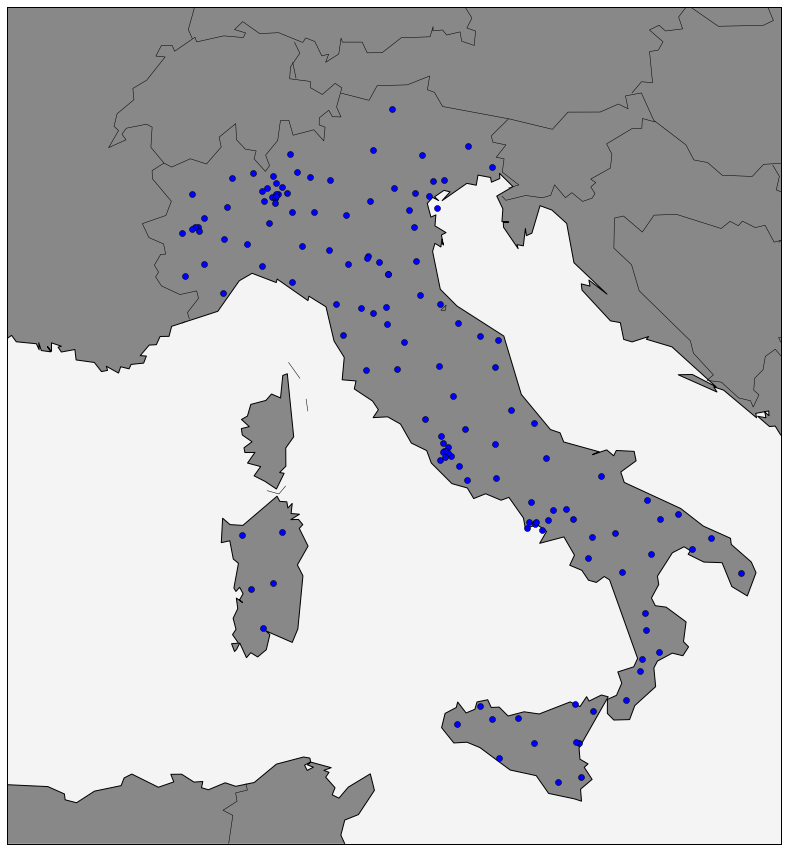

In [10]:
fig = plt.figure(figsize=(15,15))
# llcrnrlat,llcrnrlon,urcrnrlat,urcrnrlon
# are the lat/lon values of the lower left and upper right corners
# of the map.
map = Basemap(projection='merc', lat_0 = 41.8919300, lon_0 = 12.5113300, resolution = 'l', 
              llcrnrlat = 36,llcrnrlon = 4, urcrnrlat = 48,urcrnrlon = 19)
 

# Draw the coastlines on the map
map.drawcoastlines()

# Draw country borders on the map
map.drawcountries()

# Fill the land with grey
map.fillcontinents(color = '#888888')

# Draw the map boundaries
map.drawmapboundary(fill_color='#f4f4f4')
 
lat = rddCoordinates.map(lambda x: x.lat).collect()
lon = rddCoordinates.map(lambda x: x.lon).collect()

x,y = map(lon, lat)
map.plot(x,y, 'bo', markersize=6)
 
plt.show()

In [11]:
# pip install geopy
from geopy.distance import vincenty

distanza_densita = 10000 # 10km 

punti = rddCoordinates.map(lambda x: (x.lat,x.lon))
coppie = punti.cartesian(punti)

distanceBetweenPoints = coppie.filter(lambda x: x[0]!=x[1]).map(
    lambda x: ((x[0],x[1]),vincenty((x[0][0],x[0][1]), (x[1][0],x[1][1])).meters))

# Distanza più piccola fra due punti
# distanceBetweenPoints.min(lambda x: x[1])

distanceBetweenPoints = distanceBetweenPoints.collect()

def find_min(row): 
    f = filter(lambda x: x[0][0][0] == row.lat and x[0][0][1] == row.lon, distanceBetweenPoints)
    
    # Non ho idea del perchè la filter non vada se fatta su quella precedente
    m = filter(lambda x: x[0][0][0] == row.lat and x[0][0][1] == row.lon and int(x[1]) < distanza_densita, distanceBetweenPoints)
    return coordinates(
        codice_istat = '',
        sottoarea = row.sottoarea,
        lat = row.lat,
        lon = row.lon,
        citta = '',
        provincia = '',
        regione = '',
        zona_italia = '',
        isola = '',
        abitanti = '',
        min_distanza = int(min(f, key=lambda x:x[1])[1]),
        densita = len(list(m))
        )
    
    return row

rddCoordinates = rddCoordinates.map(lambda x: find_min(x))
rddCoordinates.take(5)

[coordinates(codice_istat='', sottoarea=1, lat=37.57251433333334, lon=14.20335411764705, citta='', provincia='', regione='', zona_italia='', isola='', abitanti='', min_distanza=50450, densita=0),
 coordinates(codice_istat='', sottoarea=2, lat=37.33710751515152, lon=13.54329624242424, citta='', provincia='', regione='', zona_italia='', isola='', abitanti='', min_distanza=63978, densita=0),
 coordinates(codice_istat='', sottoarea=3, lat=45.331017128571396, lon=8.264631871428566, citta='', provincia='', regione='', zona_italia='', isola='', abitanti='', min_distanza=39613, densita=0),
 coordinates(codice_istat='', sottoarea=4, lat=44.83720054450263, lon=8.639266298429321, citta='', provincia='', regione='', zona_italia='', isola='', abitanti='', min_distanza=35411, densita=0),
 coordinates(codice_istat='', sottoarea=5, lat=42.49907295757578, lon=13.76170830909092, citta='', provincia='', regione='', zona_italia='', isola='', abitanti='', min_distanza=42687, densita=0)]

In [12]:
# Mappiamo le aree NORD - CENTRO - SUD

regioni = {'ABR': 'Sud', #https://it.wikipedia.org/wiki/Abruzzo
        'BAS': 'Sud', 'CAL': 'Sud', 'CAM': 'Sud', 'EMR': 'Centro', 'FVG': 'Nord', 'LAZ' : 'Centro',
       'LIG': 'Nord', 'LOM':'Nord','MAR':'Centro','MOL':'Sud','PIE':'Nord','PUG':'Sud','SAR':'Centro', 'SIC':'Sud',
       'TOS': 'Centro', 'TAA':'Nord','UMB':'Centro','VDA':'Nord','VEN':'Nord'}
def map_regione(regione):
    return regioni[regione]

In [13]:
from geopy.geocoders import Nominatim
geolocator = Nominatim()
def geocode_coordinates(x):
    
    l = geolocator.reverse(str(x.lat) + ", " + str(x.lon))
    address = (l.address).split(',')
    
    if(len(address) > 3):
        address.pop(0)
    
    while(len(address[1].strip()) > 2):
        address.pop(0)
    
    citta, provincia, regione, _ = address[0], address[1], address[2], address[1:]
    
    return coordinates(
        codice_istat = '',
        sottoarea = x.sottoarea,
        lat = x.lat,
        lon = x.lon,
        citta = citta.strip(),
        provincia = provincia.strip(),
        regione = regione.strip(),
        zona_italia = map_regione(regione.strip()),
        isola = 1 if (regione.strip() == 'SIC' or regione.strip() == 'SAR') else 0,
        abitanti = '',
        min_distanza = x.min_distanza,
        densita = x.densita
        )
rddCoordinates = rddCoordinates.map(lambda x: geocode_coordinates(x))
rddCoordinates.take(5)

[coordinates(codice_istat='', sottoarea=1, lat=37.57251433333334, lon=14.20335411764705, citta='Villarosa', provincia='EN', regione='SIC', zona_italia='Sud', isola=1, abitanti='', min_distanza=50450, densita=0),
 coordinates(codice_istat='', sottoarea=2, lat=37.33710751515152, lon=13.54329624242424, citta='Agrigento', provincia='AG', regione='SIC', zona_italia='Sud', isola=1, abitanti='', min_distanza=63978, densita=0),
 coordinates(codice_istat='', sottoarea=3, lat=45.331017128571396, lon=8.264631871428566, citta='Salasco', provincia='VC', regione='PIE', zona_italia='Nord', isola=0, abitanti='', min_distanza=39613, densita=0),
 coordinates(codice_istat='', sottoarea=4, lat=44.83720054450263, lon=8.639266298429321, citta='Bosco Marengo', provincia='AL', regione='PIE', zona_italia='Nord', isola=0, abitanti='', min_distanza=35411, densita=0),
 coordinates(codice_istat='', sottoarea=5, lat=42.49907295757578, lon=13.76170830909092, citta='Arsita', provincia='TE', regione='ABR', zona_italia

In [14]:
comuni = namedtuple("comune", ['codice_istat', 'nome','abitanti'])

def do_parse_comuni(x):
    return comuni(
        codice_istat = str(x[0]),
        nome = str(x[1]),
        abitanti = int(x[7]) + int(x[12])
        )

def parse_comuni(sc,filepath):
    rawRdd = sc.textFile(filepath)
    header = rawRdd.first()

    # Togliamo l'header
    rawRdd = rawRdd.filter(lambda x: x != header)
    
    # Teniamo solo il totale degli abitanti (999)
    return rawRdd.map(lambda x: x.split(",")).filter(lambda x: x[2] == '999').map(lambda x: do_parse_comuni(x))

In [15]:
rddComuni = parse_comuni(sc,"dataset/ISTAT/comuni.csv")

In [16]:
rddComuni.take(5)

[comune(codice_istat='1001', nome='Agliè', abitanti=2631),
 comune(codice_istat='1002', nome='Airasca', abitanti=3794),
 comune(codice_istat='1003', nome='Ala di Stura', abitanti=469),
 comune(codice_istat='1004', nome="Albiano d'Ivrea", abitanti=1718),
 comune(codice_istat='1005', nome='Alice Superiore', abitanti=700)]

In [17]:
comuni_list = rddComuni.collect()

# Map table per correggere alcuni nomi
eccezioni_comuni = {
    "Sant'Agata li Battiati" : "Sant'Agata li Batti",
    "Villanders - Villandro" : "Villandro",
    "San Nicola da Crissa" : "San Nicola da Criss",
    "San Mango sul Calore" : "San Mango sul Calor",
    "Castiglione Chiavarese" : "Castiglione Chiavar",
    "San Martino in Strada" : "San Martino in Stra",
    "San Giorgio delle Pertiche" : "San Giorgio delle P",
    "Pinzano al Tagliamento" : "Pinzano al Tagliame",
    "Alà/Alà dei Sardi" : "Alà dei Sardi",
    "Meana/Meana Sardo" : "Meana Sardo",
    "Prammas/Palmas Arborea" : "Palmas Arborea",
    "Deximumannu/Decimomannu" : "Decimomannu",
    
    # Approssimazioni
    "Comunità Montana della Valle Brembana" : "Val Brembilla",
    "Comunità montana della valle Trompia" : "Lodrino"
}

def map_popolazione(row):
    nome_corretto = eccezioni_comuni[row.citta] if row.citta in eccezioni_comuni else row.citta
    f = list(filter(lambda x: x.nome == nome_corretto, comuni_list))
    abitanti = -1 if len(f) == 0 else f[0][2]
    istat = -1 if len(f) == 0 else int(f[0][0])
    return coordinates(
        codice_istat = istat,
        sottoarea = row.sottoarea,
        lat = row.lat,
        lon = row.lon,
        citta = row.citta,
        provincia = row.provincia,
        regione = row.regione,
        zona_italia = row.zona_italia,
        isola = row.isola,
        min_distanza = row.min_distanza,
        densita = row.densita,
        abitanti = abitanti
        )
rddCoordinates = rddCoordinates.map(lambda x: map_popolazione(x))

In [18]:
rddCoordinates.take(5)

[coordinates(codice_istat=86020, sottoarea=1, lat=37.57251433333334, lon=14.20335411764705, citta='Villarosa', provincia='EN', regione='SIC', zona_italia='Sud', isola=1, abitanti=4937, min_distanza=50450, densita=0),
 coordinates(codice_istat=84001, sottoarea=2, lat=37.33710751515152, lon=13.54329624242424, citta='Agrigento', provincia='AG', regione='SIC', zona_italia='Sud', isola=1, abitanti=59770, min_distanza=63978, densita=0),
 coordinates(codice_istat=2126, sottoarea=3, lat=45.331017128571396, lon=8.264631871428566, citta='Salasco', provincia='VC', regione='PIE', zona_italia='Nord', isola=0, abitanti=222, min_distanza=39613, densita=0),
 coordinates(codice_istat=6021, sottoarea=4, lat=44.83720054450263, lon=8.639266298429321, citta='Bosco Marengo', provincia='AL', regione='PIE', zona_italia='Nord', isola=0, abitanti=2457, min_distanza=35411, densita=0),
 coordinates(codice_istat=67003, sottoarea=5, lat=42.49907295757578, lon=13.76170830909092, citta='Arsita', provincia='TE', regio

Pandas
---

In [20]:
import pandas as pd

In [22]:
collected_rdd = rddCoordinates.collect()

In [23]:
df = pd.DataFrame.from_records(collected_rdd,columns = coordinates._fields)

ipref_df = pd.read_csv('dataset/output/ipref_processed.csv')
df_occ = pd.read_csv('dataset/output/occupazione_processed.csv', sep = ',')
istruzione_df = pd.read_csv('dataset/output/istruzione_processed.csv', sep = ',')

df = pd.merge(df, ipref_df, left_on = 'codice_istat', right_on = 'codice_istat', how = 'left')
df = pd.merge(df, istruzione_df, left_on = 'codice_istat', right_on = 'codice_istat', how = 'left')
df = pd.merge(df, df_occ, left_on = 'codice_istat', right_on = 'codice_istat', how = 'left')

In [24]:
df

,codice_istat,sottoarea,lat,lon,citta,provincia,regione,zona_italia,isola,abitanti,min_distanza,densita,reddito_medio,gini_index,indice_istruzione,forza_lavoro,occupazione
0,86020,1,37.572514,14.203354,Villarosa,EN,SIC,Sud,1,4937,50450,0,12270,0.557647,34.12,0.380192,0.828331
1,84001,2,37.337108,13.543296,Agrigento,AG,SIC,Sud,1,59770,63978,0,18990,0.527970,52.52,0.454642,0.806125
2,2126,3,45.331017,8.264632,Salasco,VC,PIE,Nord,0,222,39613,0,17050,0.539855,34.15,0.559809,0.888889
3,6021,4,44.837201,8.639266,Bosco Marengo,AL,PIE,Nord,0,2457,35411,0,20531,0.566945,33.22,0.511975,0.939982
4,67003,5,42.499073,13.761708,Arsita,TE,ABR,Sud,0,829,42687,0,12084,0.571841,30.03,0.480454,0.863517
5,66006,6,42.011072,13.463006,Avezzano,AQ,ABR,Sud,0,42515,53974,0,18928,0.521314,54.83,0.534689,0.868431
6,69098,7,42.316752,14.218194,Vacri,CH,ABR,Sud,0,1686,42687,0,11973,0.567650,33.12,0.453199,0.931649
7,94004,8,41.817024,14.442910,Belmonte del Sannio,IS,MOL,Sud,0,768,58539,0,12079,0.621604,25.36,0.376731,0.871324
8,41067,9,43.733491,12.741713,Urbino,PU,MAR,Centro,0,15019,40465,0,19349,0.540709,49.64,0.517190,0.927377
9,42041,10,43.549013,13.174615,San Marcello,AN,MAR,Centro,0,2057,27912,0,19005,0.517755,41.45,0.564804,0.945598


In [25]:
df.to_csv('dataset/output/gps_processed.csv', sep = ",")